In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import sklearn
from itertools import permutations
from pprint import pprint
from PIL import Image
import PIL
import pyodbc
from tqdm import tqdm
from random import random
import math
import seaborn as sns
from matplotlib.lines import Line2D


In [ ]:
plt.ion()   # interactive mode
testimages = list()
testclasses = list()
testindices = list()
testinitialized = 0
PATH = './test_net1.tar'
classes = ('AtHome','Hospitalized','Intubated','HospitalizedDeceased','IntubatedDeceased','Deceased')
columns = ['Male','Pneumonia','Pregnant','Diabetes','Asthma','Immunocompromised','Hypertension','Other Disease','Cardiovascular Disease','Obesity','Kidney Disease','Tobacco Use','Contact with Another Case','COPD','Recovered']

In [2]:
#create generator function for data acquisition and conversion to torch image format.
#function must return a tuple of form (tensor containing 4 images,tensor containing 4 labels)
#also builds a test set using a quick and dirty random number method.  this will need to be 
#improved to balance both the test and train sets across potential labels.
def nextrow():
    conn = pyodbc.connect('DSN=covid;UID=seh;PWD=Welcome2020!;')
    crsr = conn.cursor()
    crsr.execute("{CALL getpydata}")
    rowcnt = 0
    imgs = list()
    labels = list()
    row = [0,1,2]
    idx = 0
    while row:
        while (rowcnt<4):
            row = crsr.fetchone()
            rowcnt += 1
            if row:
                icol = 0
                irow = 0
                imgdata = np.zeros((54,54,3),dtype=np.float32)
                for px in permutations(list(row[0]),3):
                    imgdata[icol,irow,:] = [float(px[0]),float(px[1]),float(px[2])]
                    irow += 1
                    if (irow > 52):
                        icol += 1
                        irow = 0
                for age in range(0,100):
                    if age <= int(row[1]) + 1:
                        imgdata[icol,irow,:] = [0.8,0.8,0.6]
                    else:
                        break
                    irow += 1
                    if (irow > 52):
                        icol += 1
                        irow = 0
                imgtensor = TF.normalize(TF.to_tensor(imgdata),(0.5,0.5,0.5),(0.5,0.5,0.5))
                if row[2] == '000':
                    labels.append(0)
                elif row[2] == '100':
                    labels.append(1)
                elif row[2] == '110':
                    labels.append(2)
                elif row[2] == '101':
                    labels.append(3)
                elif row[2] == '111':
                    labels.append(4)
                elif row[2] == '001':
                    labels.append(5)
                imgs.append(imgtensor)
            else:
                break
        if row:
            if (testinitialized == 0):
                if (random() < 0.1):
                    testimages.append(torch.stack(imgs))
                    testclasses.append(torch.tensor(labels))
                    testindices.append(idx)
                else:
                    yield torch.stack(imgs),torch.tensor(labels)
            elif (idx not in testindices):
                yield torch.stack(imgs),torch.tensor(labels)
            rowcnt = 0
            idx += 1
            imgs = list()
            labels = list()
        else:
            break


In [8]:
def interpretimagetensor(imgtensor):
    ptsdata = list()
    for (bindata,age) in getbindatafromimagetensor(imgtensor):
        ptdata = str(age) + ' yo, '
        for i, val in enumerate(list(bindata)):
            if i == 0:
                if val == '1':
                    ptdata += 'Male, '
                else:
                    ptdata += 'Female, '
            elif val == '1':
                ptdata += columns[i] + ', '
        ptdata = ptdata[:-2]
        ptsdata.append(ptdata)
    return ptsdata

def getbindatafromimagetensor(imgtensor):
    ptsdata = list()
    for case in imgtensor:
        case = case / 2 + 0.5
        case = case.numpy()
        case = np.transpose(case, (1, 2, 0))
        bindata = str(int(case[0,0,0])) + str(int(case[0,0,1])) + str(int(case[0,0,2]))
        for i in range(1,13):
            bindata += str(int(case[0,i,2]))
        age = 0
        for p1 in case[51:,:,0]:
            for p2 in p1:
                if str(p2) == '0.8':
                    age += 1
        age -= 2
        ptsdata.append((bindata, age))
    return ptsdata


In [4]:
#the net below is built from the CIFAR tutorial in pytorch
#needs major changes to function correctly in this application
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 10 * 10, 120)  # --> found that this had to be 16x10x10 from shape print statements in forward function
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6) #-->was 10 because number of classes in example was 10.  we have 6 classes.

    def forward(self, x):
        #print(np.shape(x))
        x = self.pool(F.relu(self.conv1(x)))
        #print(np.shape(x))
        x = self.pool(F.relu(self.conv2(x)))
        #print(np.shape(x))
        x = x.view(-1, 16 * 10 * 10)
        #print(np.shape(x))
        x = F.relu(self.fc1(x))
        #print(np.shape(x))
        x = F.relu(self.fc2(x))
        #print(np.shape(x))
        x = self.fc3(x)
        #print(np.shape(x))
        return x

net = Net()

#loss function and optimizer were set based on CIFAR example also
#need to experiment with different hyperparameters and types
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [5]:
#train a new model

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    rowgen = nextrow()
    for i, data in enumerate(rowgen):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

testinitialized = 1
#save test set and model state dictionary for loading later without training.            
torch.save({'model_state_dict':net.state_dict(),
            'testimages': testimages,
            'testclasses': testclasses,
            'testindices': testindices}, PATH)
print('Finished Training')

[1,   200] loss: 1.142
[1,   400] loss: 1.002
[1,   600] loss: 0.948
[1,   800] loss: 0.931
[1,  1000] loss: 0.898
[1,  1200] loss: 0.825
[1,  1400] loss: 0.813
[1,  1600] loss: 0.730
[1,  1800] loss: 0.794
[1,  2000] loss: 0.711
[1,  2200] loss: 0.562
[1,  2400] loss: 0.698
[1,  2600] loss: 0.698
[1,  2800] loss: 0.760
[1,  3000] loss: 0.702
[1,  3200] loss: 0.729
[1,  3400] loss: 0.798
[1,  3600] loss: 0.807
[1,  3800] loss: 0.917
[1,  4000] loss: 0.918
[1,  4200] loss: 0.935
[1,  4400] loss: 0.897
[1,  4600] loss: 0.892
[1,  4800] loss: 0.984
[1,  5000] loss: 0.921
[1,  5200] loss: 0.958
[1,  5400] loss: 0.830
[1,  5600] loss: 0.851
[1,  5800] loss: 0.930
[1,  6000] loss: 0.867
[1,  6200] loss: 0.819
[1,  6400] loss: 0.817
[1,  6600] loss: 0.762
[1,  6800] loss: 0.799
[1,  7000] loss: 0.788
[1,  7200] loss: 0.746
[1,  7400] loss: 0.814
[1,  7600] loss: 0.823
[1,  7800] loss: 0.778
[1,  8000] loss: 0.787
[1,  8200] loss: 0.765
[1,  8400] loss: 0.771
[1,  8600] loss: 0.868
[1,  8800] 

In [5]:
#skip training and load saved model
checkpoint = torch.load(PATH)
net = Net()
net.load_state_dict(checkpoint['model_state_dict'])
testimages = checkpoint['testimages']
testclasses = checkpoint['testclasses']
testindices = checkpoint['testindices']
testinitialized = 1
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [6]:
#create generator function for test set

def gentestdata(startindex = 0):
    for i,classes in enumerate(testclasses,startindex):
        yield testimages[i],classes

def gettestdata(idx = 0):
    return testimages[idx],testclasses[idx]

In [21]:
#test model accuracy
correct = 0
total = 0
with torch.no_grad():
    genfunc = gentestdata(0)
    for i,data in enumerate(genfunc,0):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 200 == 199:
            print('Accuracy of the network on the first %i test images: %d %%' % (i,100 * correct / total))

print('Accuracy of the network on all %i test images: %d %%' % (i,100 * correct / total))


Accuracy of the network on the first 199 test images: 72 %
Accuracy of the network on the first 399 test images: 73 %
Accuracy of the network on the first 599 test images: 72 %
Accuracy of the network on the first 799 test images: 72 %
Accuracy of the network on the first 999 test images: 72 %
Accuracy of the network on all 1165 test images: 72 %


In [7]:
#test random image from test set
randomstartindex = math.floor(len(testimages)*random())
print(randomstartindex)
images, labels = gettestdata(randomstartindex)
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    sm = nn.Softmax()
    outcomes = np.array(sm(outputs))
    ptinfo = interpretimagetensor(images)
    for i, case in enumerate(outcomes):
        print(ptinfo[i] + '--Home Recovery: %2.1f %%, Hospital Stay: %2.1f %%, ICU/Intubation: %2.1f %%, Death: %2.1f %%' 
                % (case[0]*100,sum(case[1:5])*100,(case[2]+case[4])*100,sum(case[3:])*100))
    print('Predicted: ', ' '.join('%20s' % classes[predicted[j]] for j in range(4)))
    print('Actual:    ', ' '.join('%20s' % classes[labels[j]] for j in range(4)))

1163
57 yo Male, Hypertension, Contact with Another Case--Home Recovery: 84.4 %, Hospital Stay: 14.5 %, ICU/Intubation: 1.1 %, Death: 2.6 %
51 yo Female, Pneumonia, Hypertension--Home Recovery: 8.5 %, Hospital Stay: 89.1 %, ICU/Intubation: 14.6 %, Death: 32.8 %
67 yo Female, Pneumonia, Hypertension, Cardiovascular Disease, Obesity--Home Recovery: 7.7 %, Hospital Stay: 88.3 %, ICU/Intubation: 20.6 %, Death: 41.5 %
70 yo Male, Pneumonia, Hypertension, Tobacco Use--Home Recovery: 7.3 %, Hospital Stay: 90.5 %, ICU/Intubation: 14.1 %, Death: 31.9 %
Predicted:                AtHome         Hospitalized         Hospitalized         Hospitalized
Actual:             Hospitalized         Hospitalized HospitalizedDeceased         Hospitalized


In [26]:
#model results by class
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    genfunc = gentestdata(0)
    for data in genfunc:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(6):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of AtHome : 92 %
Accuracy of Hospitalized : 63 %
Accuracy of Intubated :  0 %
Accuracy of HospitalizedDeceased :  0 %
Accuracy of IntubatedDeceased :  0 %
Accuracy of Deceased :  0 %


In [9]:
labelstats = dict()
for c in classes:
    labelstats[c] = {
        "predprobs" : list(),
        "age" : list(),
        "sex" : list(),
        "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        sm = nn.Softmax()
        outcomes = np.array(sm(outputs))
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            thisdict = labelstats[classes[labels[i]]]
            thisdict['predprobs'].append(list(case))
            thisinfo = ptinfo[i].split(', ')
            thisdict['age'].append(int(thisinfo[0].strip(' yo')))
            thisdict['sex'].append(thisinfo[1])
            thisdict['conditions'].append(thisinfo[2:])



100%|██████████| 1166/1166 [00:10<00:00, 112.11it/s]


In [38]:
flatlblstats = {
    "truth" : list(),
    "predprobs" : list(),
    "age" : list(),
    "conditions" : list()
    }

with torch.no_grad():
    genfunc = gentestdata(0)
    for j, (images,labels) in tqdm(enumerate(genfunc,0),total=len(testimages)):
        outputs = net(images)
        sm = nn.Softmax()
        outcomes = np.array(sm(outputs))
        ptinfo = interpretimagetensor(images)
        for i, case in enumerate(outcomes):
            flatlblstats['truth'].append(classes[labels[i]])
            flatlblstats['predprobs'].append(list(case))
            thisinfo = ptinfo[i].split(', ')
            flatlblstats['age'].append(int(thisinfo[0].strip(' yo')))
            if thisinfo[1] == 'Male':
                flatlblstats['conditions'].append(thisinfo[1:])
            else:
                flatlblstats['conditions'].append(thisinfo[2:])



100%|██████████| 1166/1166 [00:09<00:00, 122.33it/s]


In [141]:
predsbyage = {
    'age': list(),
    }
actualbyage = {
    'age': list(),
    }
for c in classes:
    predsbyage[c] = list()
    actualbyage[c] = list()

for i in tqdm(range(100)):
    predsums = np.zeros(6,dtype=np.float32)
    actsums = np.zeros(6,dtype=np.float32)
    #actsums *= 10
    for j,ag in enumerate(flatlblstats['age']):
        if ag == i:
            for k, val in enumerate(flatlblstats['predprobs'][j]):
                predsums[k] += val
            actsums[classes.index(flatlblstats['truth'][j])] += 1.0
    predsbyage['age'].append(i)
    actualbyage['age'].append(i)
    for j, c in enumerate(classes):
        predsbyage[c].append(predsums[j])
        actualbyage[c].append(actsums[j])



100%|██████████| 100/100 [00:00<00:00, 439.75it/s]


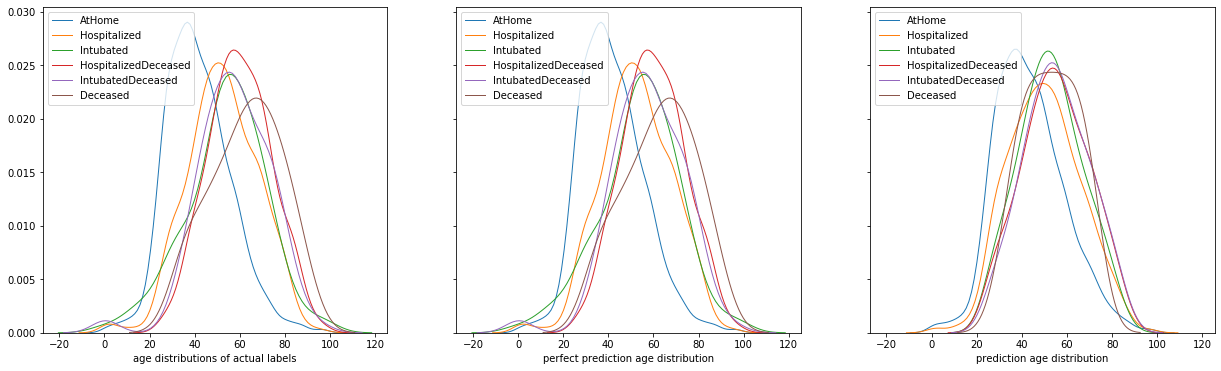

In [147]:
agedistfromactual = dict()
agedistfrompreds = dict()
for c in classes:
    agedistfromactual[c] = list()
    agedistfrompreds[c] = list()
    for i,val in enumerate(actualbyage[c]):
        agedistfromactual[c].extend([i]*int(val))
    for i,val in enumerate(predsbyage[c]):
        agedistfrompreds[c].extend([i]*int(round(val)))

fig, axs = plt.subplots(1,3,figsize=(21,6),sharex=True,sharey=True)
for i in range(6):
    sns.distplot(labelstats[classes[i]]['age'], hist = False, kde = True,kde_kws = {'linewidth': 1},label = classes[i],ax=axs[0],axlabel="age distributions of actual labels")
    sns.distplot(agedistfromactual[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1},label = classes[i],ax=axs[1],axlabel="perfect prediction age distribution")
    sns.distplot(agedistfrompreds[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1},label = classes[i],ax=axs[2],axlabel="prediction age distribution")
    #axs[1].scatter(actualbyage['age'],actualbyage[classes[i]]/sum(actualbyage[classes[i]]),label=classes[i],s=7)
    #axs[2].scatter(predsbyage['age'],predsbyage[classes[i]]/sum(predsbyage[classes[i]]),label=classes[i],s=7)

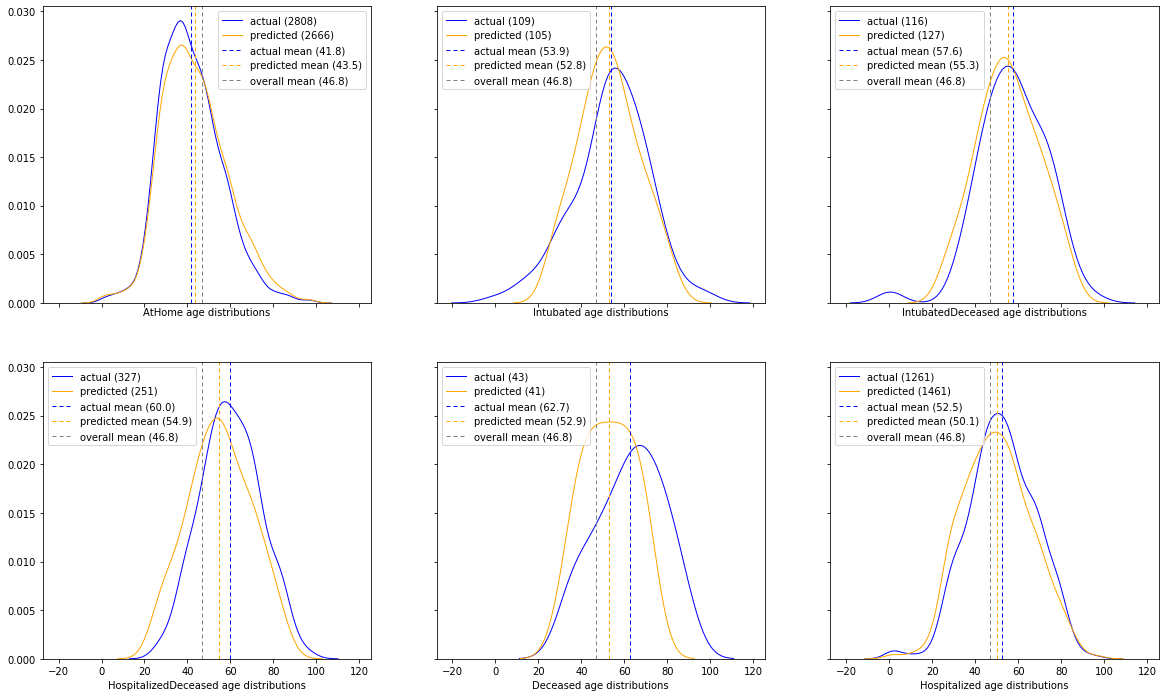

In [166]:
fix, axs = plt.subplots(2,3,figsize=(20,12),sharex=True,sharey=True)
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='orange', lw=1),
                Line2D([0], [0], color='blue', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='orange', lw=1, dashes=(4.,3.)),
                Line2D([0], [0], color='grey', lw=1, dashes=(4.,3.))]
for i in range(6):
    sns.distplot(labelstats[classes[i]]['age'], hist = False, kde = True,kde_kws = {'linewidth': 1}
                    ,ax=axs[(6 - i)%2,(6 - i)%3],axlabel=classes[i]+' age distributions',color='blue')
    sns.distplot(agedistfrompreds[classes[i]], hist = False, kde = True,kde_kws = {'linewidth': 1}
                    ,ax=axs[(6 - i)%2,(6 - i)%3],color='orange')
    axs[(6 - i)%2,(6 - i)%3].axvline(x=round(np.mean(flatlblstats['age']),1),color='grey',dashes=(4.,3.),lw=1)
    axs[(6 - i)%2,(6 - i)%3].axvline(x=round(np.mean(labelstats[classes[i]]['age']),1),color='blue',dashes=(4.,3.),lw=1)
    axs[(6 - i)%2,(6 - i)%3].axvline(x=round(np.mean(agedistfrompreds[classes[i]]),1),color='orange',dashes=(4.,3.),lw=1)
    axs[(6 - i)%2,(6 - i)%3].legend(custom_lines,('actual ('+str(len(labelstats[classes[i]]['age']))+')','predicted ('+str(len(agedistfrompreds[classes[i]]))+')'
                                                    ,'actual mean ('+str(round(np.mean(labelstats[classes[i]]['age']),1))+')'
                                                    ,'predicted mean ('+str(round(np.mean(agedistfrompreds[classes[i]]),1))+')'
                                                    ,'overall mean ('+str(round(np.mean(flatlblstats['age']),1))+')'))

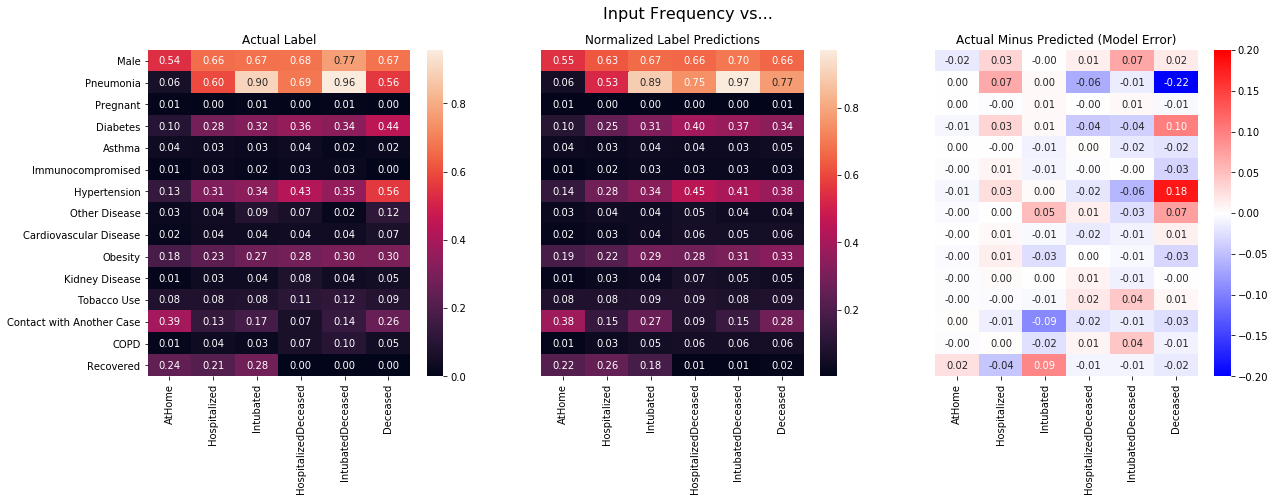

In [168]:
truthcondheatmap = np.zeros((6,15),dtype=np.float32)
predcondheatmap = np.zeros((15,6),dtype=np.float32)
for i,trth in enumerate(flatlblstats['truth']):
    for cond in flatlblstats['conditions'][i]:
        truthcondheatmap[classes.index(trth),columns.index(cond)] += 1
        predcondheatmap[columns.index(cond)] += flatlblstats['predprobs'][i]
predcondheatmap = predcondheatmap.T
for i in range(6):
    truthcondheatmap[i] /= len(labelstats[classes[i]]['age'])
    predcondheatmap[i] /= sum(predsbyage[classes[i]])
fig, axs = plt.subplots(1,3,figsize=(20,6))
sns.heatmap(truthcondheatmap.T,ax=axs[0],yticklabels=columns,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap(predcondheatmap.T,ax=axs[1],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f')
sns.heatmap((truthcondheatmap - predcondheatmap).T,ax=axs[2],yticklabels=False,xticklabels=classes,annot=True,fmt='.2f',cmap='bwr',vmin=-0.2,vmax=0.2)
fig.suptitle('Input Frequency vs...',fontsize=16)
axs[0].title.set_text('Actual Label')
axs[1].title.set_text('Normalized Label Predictions')
axs[2].title.set_text('Actual Minus Predicted (Model Error)')